In [1]:
import numpy as np
import tempfile
import tensorflow as tf

from tf_rl.controller import DiscreteDeepQ, HumanController
from tf_rl.simulation import KarpathyGame
from tf_rl import simulate
from tf_rl.models import MLP

In [20]:
LOG_DIR = tempfile.mkdtemp()
print(LOG_DIR)

/tmp/tmp3rSEdd


In [234]:
from random import randint, gauss

import numpy as np

class DiscreteHill(object):
    
    directions = [(0,1), (0,-1), (1,0), (-1,0)]
    
    def __init__(self, board=(10,10), variance=4.):
        self.variance = variance
        self.target   = (randint(-board[0], board[0]), randint(-board[1], board[1]))
        self.position = (randint(-board[0], board[0]), randint(-board[1], board[1]))
    
    @staticmethod
    def add(p, q):
        return (p[0] + q[0], p[1] + q[1])
        
    @staticmethod
    def distance(p, q):
        return abs(p[0] - q[0]) + abs(p[1] - q[1])
    
    def estimate_distance(self, p):
        distance = DiscreteHill.distance(self.target, p) - DiscreteHill.distance(self.target, self.position)
        return distance + abs(gauss(0, self.variance))
        
    def observe(self):    
        return np.array([self.estimate_distance(DiscreteHill.add(self.position, delta)) 
                         for delta in DiscreteHill.directions])
    
    def perform_action(self, action):
        self.position = DiscreteHill.add(self.position, DiscreteHill.directions[action])
        
    def is_over(self):
        return self.position == self.target
    
    def collect_reward(self, action):
        return -DiscreteHill.distance(self.target, DiscreteHill.add(self.position, DiscreteHill.directions[action])) \
            + DiscreteHill.distance(self.target, self.position) - 2

In [222]:
# Tensorflow business - it is always good to reset a graph before creating a new controller.
tf.ops.reset_default_graph()
session = tf.InteractiveSession()

# This little guy will let us run tensorboard
#      tensorboard --logdir [LOG_DIR]
journalist = tf.train.SummaryWriter(LOG_DIR)

# Brain maps from observation to Q values for different actions.
# Here it is a done using a multi layer perceptron with 2 hidden
# layers
brain = MLP([4,], [10, 4], 
            [tf.tanh, tf.identity])

# The optimizer to use. Here we use RMSProp as recommended
# by the publication
optimizer = tf.train.RMSPropOptimizer(learning_rate= 0.001, decay=0.9)

# DiscreteDeepQ object
current_controller = DiscreteDeepQ(4, 4, brain, optimizer, session,
                                   discount_rate=0.9, exploration_period=100, max_experience=10000, 
                                   store_every_nth=1, train_every_nth=4, target_network_update_rate=0.1,
                                   summary_writer=journalist)

session.run(tf.initialize_all_variables())
session.run(current_controller.target_network_update)
# graph was not available when journalist was created  
journalist.add_graph(session.graph_def)

Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7fa08c379310>> ignored


In [248]:
try:
    for game_idx in range(1000000):
        game = DiscreteHill()
        game_iterations = 0

        observation = game.observe()

        while game_iterations < 50 and not game.is_over():
            action = current_controller.action(observation)
            reward = game.collect_reward(action)
            game.perform_action(action)
            new_observation = game.observe()
            current_controller.store(observation, action, reward, new_observation)
            current_controller.training_step()
            observation = new_observation
            game_iterations += 1
        print "\rGame %d: iterations before success %d." % (game_idx, game_iterations),
        
        print "Pos: %s, Target: %s" % (game.position, game.target),
except KeyboardInterrupt:
    print "Interrupted"

Game 2174: iterations before success 50. Pos: (-9, 2), Target: (-10, 6) Interrupted


In [247]:
game.observe()

array([-0.27581323,  2.42700684,  6.47071694, -0.1583888 ])

<matplotlib.colorbar.Colorbar instance at 0x7fa050305dd0>

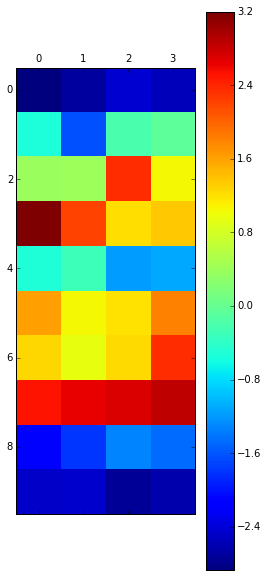

In [231]:
x = brain.layers[0].Ws[0].eval()
import matplotlib.pyplot as plt
%matplotlib inline
plt.matshow(x)
plt.colorbar()

In [138]:
brain.input_layer.b.eval()

array([ 11.01352692,  11.28201485,  12.03692055,  12.26954937], dtype=float32)

In [88]:
game.collect_reward(0)

-2.0